In [12]:
# Impor Library yang diperlukan
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Hubungkan Google Drive
drive.mount('/content/drive')

# Muat dataset
mental_health_data = pd.read_csv('/content/drive/My Drive/Data_Mining/MentalHealthSurvey.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Tampilkan beberapa baris pertama dan statistik ringkas
print(mental_health_data.head())

   gender  age university   degree_level      degree_major academic_year  \
0    Male   20         PU  Undergraduate      Data Science      2nd year   
1    Male   20        UET   Postgraduate  Computer Science      3rd year   
2    Male   20       FAST  Undergraduate  Computer Science      3rd year   
3    Male   20        UET  Undergraduate  Computer Science      3rd year   
4  Female   20        UET  Undergraduate  Computer Science      3rd year   

      cgpa residential_status campus_discrimination sports_engagement  ...  \
0  3.0-3.5         Off-Campus                    No         No Sports  ...   
1  3.0-3.5         Off-Campus                    No         1-3 times  ...   
2  2.5-3.0         Off-Campus                    No         1-3 times  ...   
3  2.5-3.0          On-Campus                    No         No Sports  ...   
4  3.0-3.5         Off-Campus                   Yes         No Sports  ...   

  study_satisfaction  academic_workload   academic_pressure  \
0          

In [15]:
print(mental_health_data.describe())

             age  study_satisfaction  academic_workload   academic_pressure  \
count  87.000000           87.000000           87.000000          87.000000   
mean   19.942529            3.931034            3.885057           3.781609   
std     1.623636            1.043174            0.854880           1.125035   
min    17.000000            1.000000            2.000000           1.000000   
25%    19.000000            3.000000            3.000000           3.000000   
50%    20.000000            4.000000            4.000000           4.000000   
75%    21.000000            5.000000            4.500000           5.000000   
max    26.000000            5.000000            5.000000           5.000000   

       financial_concerns  social_relationships  depression    anxiety  \
count           87.000000             87.000000   87.000000  87.000000   
mean             3.390805              2.781609    3.218391   3.218391   
std              1.400634              1.175578    1.367609   1.29

In [16]:
# Hilangkan spasi tambahan pada nama kolom
mental_health_data.columns = mental_health_data.columns.str.strip()

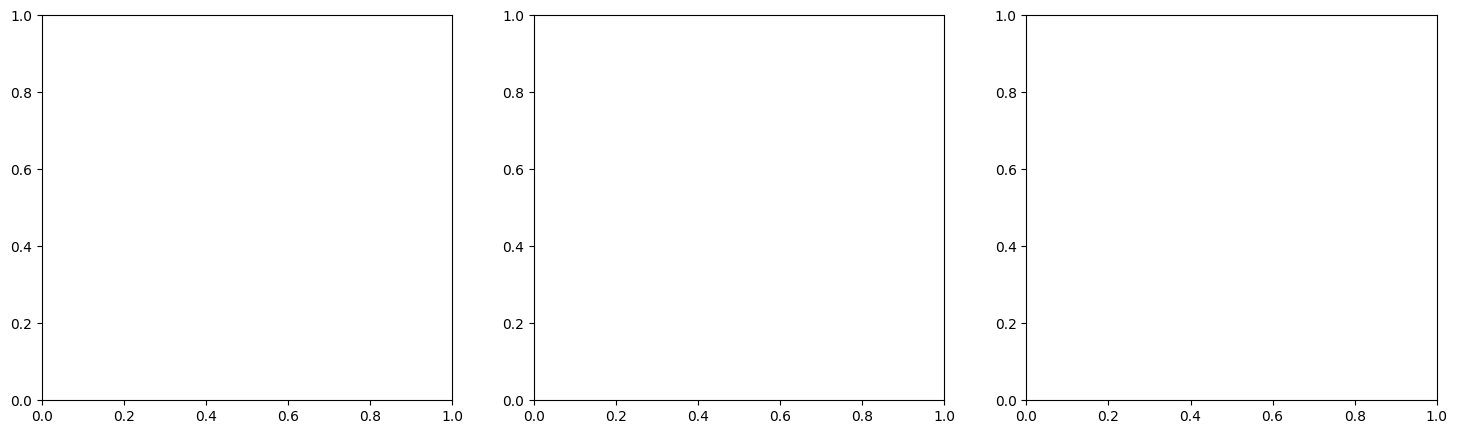

In [17]:
# Visualisasi distribusi depresi, kecemasan, dan isolasi
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

In [18]:
# Distribusi skor depresi
sns.histplot(mental_health_data['depression'], kde=True, ax=axs[0], bins=5)
axs[0].set_title('Distribusi Skor Depresi')
axs[0].set_xlabel('Skor Depresi')

# Distribusi skor kecemasan
sns.histplot(mental_health_data['anxiety'], kde=True, ax=axs[1], bins=5)
axs[1].set_title('Distribusi Skor Kecemasan')
axs[1].set_xlabel('Skor Kecemasan')

# Distribusi skor isolasi
sns.histplot(mental_health_data['isolation'], kde=True, ax=axs[2], bins=5)
axs[2].set_title('Distribusi Skor Isolasi')
axs[2].set_xlabel('Skor Isolasi')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [19]:
# Hitung matriks korelasi untuk kolom yang relevan
correlation_matrix = mental_health_data[
    ['depression', 'anxiety', 'isolation', 'study_satisfaction',
     'academic_workload', 'academic_pressure', 'financial_concerns',
     'social_relationships', 'future_insecurity']
].corr()

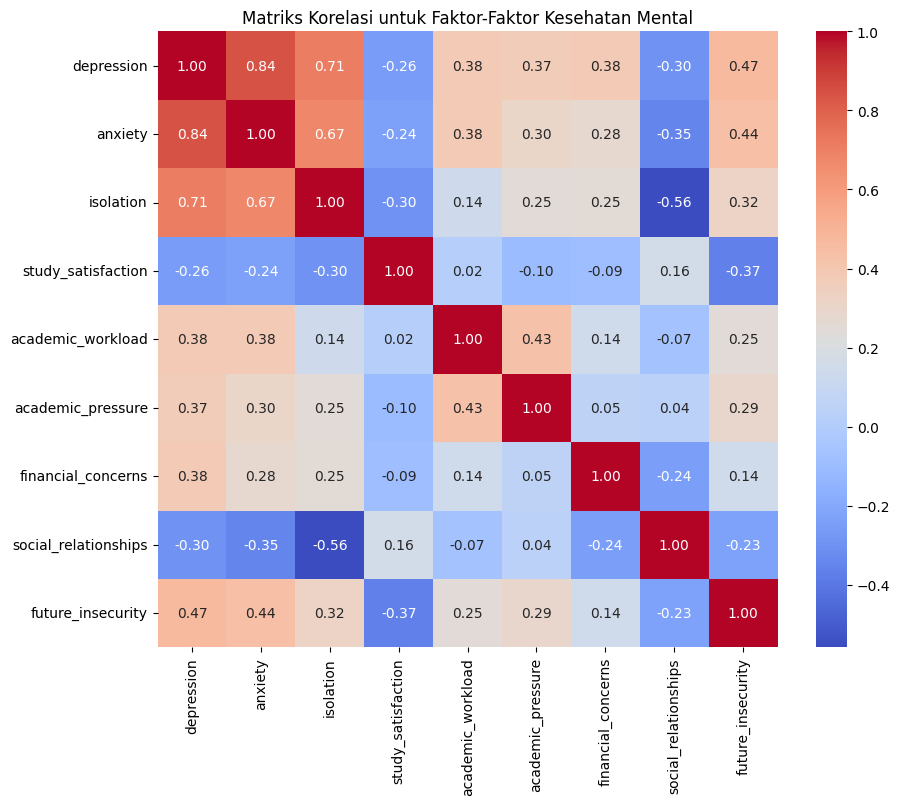

In [20]:
# Visualisasikan matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi untuk Faktor-Faktor Kesehatan Mental")
plt.show()

In [21]:
# Siapkan data: tentukan variabel target dan fitur prediktor
X = mental_health_data[['study_satisfaction', 'academic_workload', 'academic_pressure',
                        'financial_concerns', 'social_relationships', 'future_insecurity']]
y = mental_health_data['depression']  # Variabel target: memprediksi tingkat depresi

In [22]:
# Menyeimbangkan data menggunakan SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [23]:
# Pemilihan fitur menggunakan Recursive Feature Elimination (RFE)
selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
selector.fit(X_balanced, y_balanced)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)

In [24]:
# Pilih fitur yang paling relevan
selected_features = X.columns[selector.support_]
print("Fitur yang Terpilih:", selected_features)

# Gunakan hanya fitur yang terpilih
X_balanced_selected = X_balanced[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)


Fitur yang Terpilih: Index(['study_satisfaction', 'academic_pressure', 'financial_concerns',
       'social_relationships', 'future_insecurity'],
      dtype='object')


In [26]:
# Penyempurnaan parameter (Hyperparameter tuning) dengan Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],            # Jumlah pohon dalam hutan
    'max_depth': [10, 20, 30, None],            # Kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],            # Minimum sampel untuk membagi node
    'min_samples_leaf': [1, 2, 4]               # Minimum sampel pada daun
}

# Lakukan Grid Search pada Random Forest
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [27]:
# Model terbaik dari hasil Grid Search
best_model = grid_search.best_estimator_
print("Parameter Terbaik:", grid_search.best_params_)

Parameter Terbaik: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [28]:
# Evaluasi model menggunakan cross-validation
scores = cross_val_score(best_model, X_balanced_selected, y_balanced, cv=5)
print("Skor Cross-validation:", scores)
print("Rata-rata akurasi:", scores.mean())

Skor Cross-validation: [0.47619048 0.38095238 0.57142857 0.61904762 0.57142857]
Rata-rata akurasi: 0.5238095238095237


In [29]:
# Latih model terbaik dengan data latih
best_model.fit(X_train, y_train)

# Prediksi menggunakan data uji
y_pred = best_model.predict(X_test)

# Evaluasi performa model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.42857142857142855

Laporan Klasifikasi:
               precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.57      0.80      0.67         5
           3       0.00      0.00      0.00         5
           4       0.33      0.20      0.25         5
           5       0.50      0.33      0.40         3

    accuracy                           0.43        21
   macro avg       0.38      0.47      0.40        21
weighted avg       0.36      0.43      0.37        21



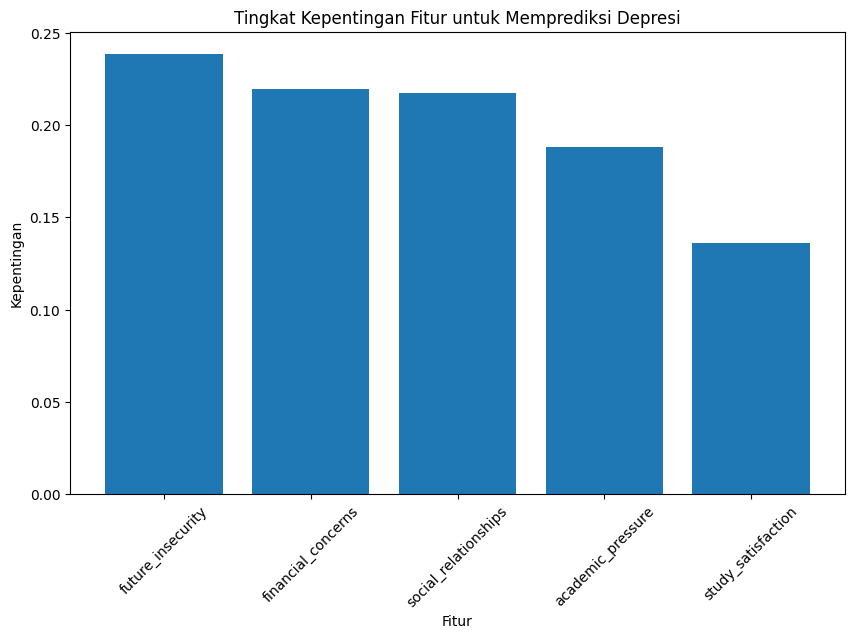

In [30]:
# Visualisasi Tingkat Kepentingan Fitur (Feature Importance)
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Tingkat Kepentingan Fitur untuk Memprediksi Depresi")
plt.bar(range(len(selected_features)), importances[indices], align="center")
plt.xticks(range(len(selected_features)), selected_features[indices], rotation=45)
plt.xlabel("Fitur")
plt.ylabel("Kepentingan")
plt.show()